In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from __future__ import print_function, division

import torchvision
from torchvision import datasets, models, transforms
import torch
from torch.optim import lr_scheduler
import torch.optim as optim

加载数据

In [2]:
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = '../datasets/insect/'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'val']}
image_dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 2) for x in ['train', 'val']}
image_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
image_classes = image_datasets['train'].classes
device = torch.device('cuda: 0' if torch.cuda.is_available() else 'cpu')

In [3]:
import copy

def train(model,  criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        for phrase in ['train', 'val']:
            if phrase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_correct = 0
            for step, (inputs, labels) in enumerate(image_dataloaders[phrase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phrase == 'train'):
                    outputs = model(inputs)
                    _, pred = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phrase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_correct += torch.sum(pred == labels.data)
            if phrase == 'train':
                scheduler.step()
        epoch_loss = running_loss/image_size[phrase]
        epoch_acc = running_correct.double()/image_size[phrase]
        print('{} Loss: {:.4f} Acc:{:.4f}'.format(phrase, epoch_loss, epoch_acc))
        if phrase == 'val'and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [4]:
model_conv = torchvision.models.resnet18(pretrained = True)
print(model_conv)
for param in model_conv.parameters():
    param.requires_grad = False
num_ftrs = model_conv.fc.in_features
print(num_ftrs)
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)
print(model_conv)

In [ ]:
train(model_conv, criterion, optimizer_conv,exp_lr_scheduler)

## Fashion-MNIST

### 导入数据

In [5]:
train_data = datasets.FashionMNIST(
    root = '../datasets/FashionMNIST',
    train = True,
    transform = transforms.ToTensor(),
    download = False
)
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 64, shuffle = True, num_workers = 2)
print('train_loader的batch_size = ', len(train_loader))

train_loader的batch_size =  938


C:\developer\Anaconda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


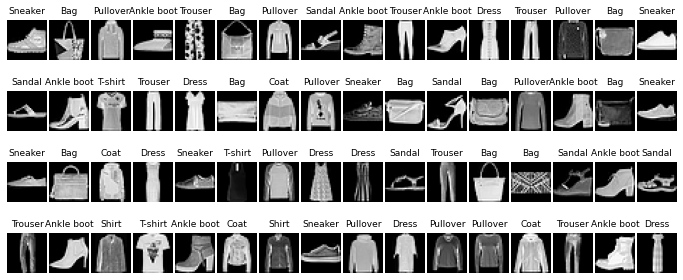

In [6]:
for step, (data, target) in enumerate(train_loader):
    if step > 0:
        break
    batch_x = data.squeeze().numpy()
    batch_y = target.numpy()
    class_label = train_data.classes
    class_label[0] = 'T-shirt'
    plt.figure(figsize = (12, 5))
    for ii in range(len(batch_y)):
        plt.subplot(4,16, ii+1)
        plt.imshow(batch_x[ii,:,:], cmap = plt.cm.gray)
        plt.title(class_label[batch_y[ii]], size = 9)
        plt.axis("off")
        plt.subplots_adjust(wspace = 0.05)

In [7]:
test_data = datasets.FashionMNIST(
    root = '../datasets/FashionMNIST',
    train = False,
    transform = transforms.ToTensor(),
    download = False
)
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
print(test_data_x.shape)
test_data_x = torch.unsqueeze(test_data_x, dim = 1)
print(test_data_x.shape)
test_data_y = test_data.targets
print(test_data_y.shape)

torch.Size([10000, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


### 设计模型

In [8]:
class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.size(0), -1)

In [9]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1,1),
            nn.ReLU(inplace = True),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, 0),
            nn.ReLU(inplace = True),
            nn.AvgPool2d(2, 2),
            Flatten(),
            nn.Linear(32 * 6 *6, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

In [10]:
myconvnet = MyConvNet()
myconvnet

MyConvNet(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten()
    (7): Linear(in_features=1152, out_features=256, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [11]:
import copy
import time
import pandas as pd
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs=25):
    """
        model:网络模型
        traindataloader:训练数据集
        train_rate:训练集占数据集的百分比
        criterion:损失函数
        optimizer:优化器
        num_epochs:迭代轮数
    """
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num * train_rate)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step, (data, target) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train()
                output = model(data)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
                train_corrects += torch.sum(pre_lab == target.data)
                train_num += data.size(0)
            else:
                model.eval()
                output = model(data)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)
                val_corrects += torch.sum(pre_lab == target.data)
                val_num += data.size(0)
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)
        print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(epoch, train_loss_all[-1], train_acc_all[-1]))
        print('{} Val Loss: {:.4f}  Val Acc: {:.4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print('Train and Val complete in {:.0f}m {:.0f}s'.format(time_use // 60, time_use % 60))
    model.load_state_diect(best_model_wts)
    train_process = pd.DataFrame(
        data = {"epoch":range(num_epochs),
                "train_loss_all":train_loss_all,
                "val_loss_all":val_loss_all,
                "train_acc_all":train_acc_all,
                "val_acc_all":val_acc_all
               }
    )
    return model, train_process

In [ ]:
optimizer = optim.Adam(myconvnet.parameters(), lr = 0.0003)
criterion = nn.CrossEntropyLoss()
myconvnet, process = train_model(myconvnet, train_loader, 0.8, criterion, optimizer)

Epoch 0 / 24
----------
0 Train Loss: 0.7736  Train Acc: 0.7200
0 Val Loss: 0.5965  Val Acc: 0.7747
Train and Val complete in 0m 22s
Epoch 1 / 24
----------
1 Train Loss: 0.5294  Train Acc: 0.8019
1 Val Loss: 0.4793  Val Acc: 0.8224
Train and Val complete in 0m 45s
Epoch 2 / 24
----------
2 Train Loss: 0.4604  Train Acc: 0.8306
2 Val Loss: 0.4322  Val Acc: 0.8414
Train and Val complete in 1m 8s
Epoch 3 / 24
----------
3 Train Loss: 0.4123  Train Acc: 0.8499
3 Val Loss: 0.3971  Val Acc: 0.8571
Train and Val complete in 1m 31s
Epoch 4 / 24
----------
4 Train Loss: 0.3803  Train Acc: 0.8619
4 Val Loss: 0.3520  Val Acc: 0.8706
Train and Val complete in 1m 54s
Epoch 5 / 24
----------
5 Train Loss: 0.3535  Train Acc: 0.8720
5 Val Loss: 0.3363  Val Acc: 0.8778
Train and Val complete in 2m 17s
Epoch 6 / 24
----------
6 Train Loss: 0.3284  Train Acc: 0.8789
6 Val Loss: 0.3637  Val Acc: 0.8702
Train and Val complete in 2m 40s
Epoch 7 / 24
----------
7 Train Loss: 0.3143  Train Acc: 0.8845
7 Val 